### Prep Data
This notebook is the primary notebook to take data in a per region format and transform it in to a format appropriate for ML problems

In [73]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
import xgboost
import xarray as xr
import numpy as np
#from dask.distributed import Client
#import dask
#import dask_xgboost
#import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import time
from functools import partial
#import multiprocessing
import os.path
#from operator import is_not
#from tsfresh import extract_relevant_features, extract_features, feature_extraction, select_features
#import dask.dataframe as dd
#import dask.array as da
from datetime import datetime
#import xgboost as xgb
#from xgboost import XGBClassifier
#from itertools import cycle
import datetime
from os import listdir
from os.path import isfile, join
import pickle

# Data structure

OAPMLData\

    1.RawWeatherData/ #Downloaded
    2.GFSDaily(x)xInterpolation/ #From ParseGFS (x) is degree of interpolation
    3.GFSFiltered(x)xInterpolation/ #From ParseGFS
    CleanedForecastsNWAC_CAIC_UAC.V1.2013-2020.csv #labels downloaded from https://oapstorageprod.blob.core.windows.net/oap-training-data/Data/V1.1FeaturesWithLabels2013-2020.zip
    4.MLData\ #Output from this notebook both intermediate .netcdf (and in some unused methods .zarr files)
         

In [75]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'
interpolation = 1

In [76]:
processed_path = data_root + '/3.GFSFiltered'+ str(interpolation) + 'xInterpolation/'
path_to_labels = data_root + 'CleanedForecastsNWAC_CAIC_UAC.V1.2013-2020.csv'
ml_path = data_root + '/4.MLData'


In [77]:
#mapping between region names as the labels and the forecasts have slightly different standards
#TODO: could add a unified mapping upstream in parseGFS files or in the label generation
def lookup_forecast_region(label_region):
    if label_region == 'Mt Hood':
        return 'Mt Hood'
    elif label_region == 'Olympics':
        return 'Olympics'
    elif label_region == 'Cascade Pass - Snoq. Pass':
        return 'Snoqualmie Pass'
    elif label_region == 'Cascade Pass - Stevens Pass':
        return 'Stevens Pass'
    elif label_region == 'Cascade East - Central':
        return 'WA Cascades East, Central'
    elif label_region == 'Cascade East - North':
        return 'WA Cascades East, North'
    elif label_region == 'Cascade East - South':
        return 'WA Cascades East, South'
    elif label_region == 'Cascade West - Central':
        return 'WA Cascades West, Central'
    elif label_region == 'Cascade West - North':
        return 'WA Cascades West, Mt Baker'
    elif label_region == 'Cascade West - South':
        return 'WA Cascades West, South'
    elif label_region == 'Abajo':
        return 'Abajos'
    elif label_region == 'Logan':
        return 'Logan'
    elif label_region == 'Moab':
        return 'Moab'
    elif label_region == 'Ogden':
        return 'Ogden'
    elif label_region == 'Provo':
        return 'Provo'
    elif label_region == 'Salt Lake':
        return 'Salt Lake'
    elif label_region == 'Skyline':
        return 'Skyline'
    elif label_region == 'Uintas':
        return 'Uintas'
    elif label_region == 'Grand Mesa':
        return 'Grand Mesa Zone'
    elif label_region == 'Sangre de Cristo':
        return 'Sangre de Cristo Range'
    elif label_region == 'Steamboat & Flat Tops':
        return 'Steamboat Zone'
    elif label_region == 'Front Range':
        return 'Front Range Zone'
    elif label_region == 'Vail & Summit County':
        return 'Vail Summit Zone'
    elif label_region == 'Sawatch Range':
        return 'Sawatch Zone'
    elif label_region == 'Aspen':
        return 'Aspen Zone'
    elif label_region == 'Northern San Juan':
        return 'North San Juan Mountains'
    elif label_region == 'Southern San Juan':
        return 'South San Juan Mountains'
    elif label_region == 'Gunnison':
        return 'Gunnison Zone'
    else:
        return 'Got region ' + label_region + ' but its an unknown region'

In [78]:
#map states to regions for purposes of data lookup
regions = {
            #'Utah': ['Abajos', 'Logan', 'Moab', 'Ogden', 'Provo', 
           #'Salt Lake', 'Skyline', 'Uintas'],  
           #'Colorado': ['Grand Mesa Zone', 'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
           #'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
           #'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone'],
           'Washington': ['Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass',
           'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South',
           'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'
           ]
           }


In [79]:
#maintaining this as a dict since the arrays are ragged and its more efficient this way
#storing one sample for each region to get the lat/lon layout
region_zones = []
region_data = {}
for region in regions.keys():
    for r in regions[region]:
        region_zones.append(r)
        region_data[r] = xr.open_dataset(processed_path + '15-16/' + region + '/Region_' + r + '_20160101.nc')
    

In [80]:
regions

{'Washington': ['Mt Hood',
  'Olympics',
  'Snoqualmie Pass',
  'Stevens Pass',
  'WA Cascades East, Central',
  'WA Cascades East, North',
  'WA Cascades East, South',
  'WA Cascades West, Central',
  'WA Cascades West, Mt Baker',
  'WA Cascades West, South']}

In [81]:
region_data['Olympics']

<xarray.Dataset>
Dimensions:                                               (latitude: 3, longitude: 4, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] 2016-01-01
  * latitude                                              (latitude) float64 47.5 ... 48.0
  * longitude                                             (longitude) float64 -123.8 ... -123.0
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                    

In [82]:
#Read in all the label data
labels = pd.read_csv(path_to_labels, low_memory=False,
        dtype={'Day1Danger_OctagonAboveTreelineEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorth': 'object',
               'Day1Danger_OctagonAboveTreelineNorthEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorthWest': 'object',
               'Day1Danger_OctagonAboveTreelineSouth': 'object',
               'Day1Danger_OctagonAboveTreelineSouthEast': 'object',
               'Day1Danger_OctagonAboveTreelineSouthWest': 'object',
               'Day1Danger_OctagonAboveTreelineWest': 'object',
               'Day1Danger_OctagonBelowTreelineEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorth': 'object',
               'Day1Danger_OctagonBelowTreelineNorthEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorthWest': 'object',
               'Day1Danger_OctagonBelowTreelineSouth': 'object',
               'Day1Danger_OctagonBelowTreelineSouthEast': 'object',
               'Day1Danger_OctagonBelowTreelineSouthWest': 'object',
               'Day1Danger_OctagonBelowTreelineWest': 'object',
               'Day1Danger_OctagonNearTreelineEast': 'object',
               'Day1Danger_OctagonNearTreelineNorth': 'object',
               'Day1Danger_OctagonNearTreelineNorthEast': 'object',
               'Day1Danger_OctagonNearTreelineNorthWest': 'object',
               'Day1Danger_OctagonNearTreelineSouth': 'object',
               'Day1Danger_OctagonNearTreelineSouthEast': 'object',
               'Day1Danger_OctagonNearTreelineSouthWest': 'object',
               'Day1Danger_OctagonNearTreelineWest': 'object',
               'SpecialStatement': 'object',
               'image_paths': 'object',
               'image_types': 'object',
               'image_urls': 'object'})
date_col = 'Day1Date'
region_col = 'UnifiedRegion'
labels['parsed_date'] = pd.to_datetime(labels[date_col], format='%Y%m%d')
parsed_date_col = 'parsed_date'
metadata_cols = [date_col, region_col]
label_cols = ['Day1DangerBelowTreeline', 'Day1DangerNearTreeline', 'Day1DangerAboveTreeline']
labels[region_col] = labels.apply(lambda x : lookup_forecast_region(x[region_col]), axis=1)
labels = labels[labels[region_col]!='Unknown region']

In [83]:
#ensure we are only using label data for regions we are looking at
labels = labels[labels[region_col].isin(region_zones)]

In [84]:
labels[region_col].value_counts()

WA Cascades East, South       885
WA Cascades West, Mt Baker    774
WA Cascades West, South       762
Olympics                      760
Snoqualmie Pass               760
WA Cascades West, Central     757
Stevens Pass                  755
WA Cascades East, Central     749
Mt Hood                       738
WA Cascades East, North       602
Name: UnifiedRegion, dtype: int64

In [85]:
#mapping of date to season
def date_to_season(d):
    if d >= np.datetime64('2014-11-01') and d <= np.datetime64('2015-04-30'):
        return (np.datetime64('2014-11-01'), '14-15')
    elif d >= np.datetime64('2015-11-01') and d <= np.datetime64('2016-04-30'):
        return (np.datetime64('2015-11-01'), '15-16')
    elif d >= np.datetime64('2016-11-01') and d <= np.datetime64('2017-04-30'):
        return (np.datetime64('2016-11-01'), '16-17')
    elif d >= np.datetime64('2017-11-01') and d <= np.datetime64('2018-04-30'):
        return (np.datetime64('2017-11-01'), '17-18')
    elif d >= np.datetime64('2018-11-01') and d <= np.datetime64('2019-04-30'):
        return (np.datetime64('2018-11-01'), '18-19')
    elif d >= np.datetime64('2019-11-01') and d <= np.datetime64('2020-04-30'):
        return (np.datetime64('2019-11-01'), '19-20')
    else:
        #print('Unknown season ' + str(d))
        return (-1,'Unknown')
    

In [86]:
labels.reset_index(drop=True, inplace=True)

In [87]:
#add a season column
tmp = pd.DataFrame.from_records(labels[parsed_date_col].apply(date_to_season))
labels['season'] = tmp[1]

In [88]:
#some region/seasons have excessive errors in the data, remove those
labels = labels[labels['season'].isin(['15-16', '16-17', '17-18', '18-19'])]
labels = labels[~labels.index.isin(labels[(labels['season']=='15-16') & (labels[region_col]=='Steamboat Zone')].index)]
labels = labels[~labels.index.isin(labels[(labels['season']=='16-17') & (labels[region_col]=='Front Range Zone')].index)]

In [89]:
labels.head()

,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,Cornices_OctagonAboveTreelineNorthEast,Cornices_OctagonAboveTreelineNorthWest,Cornices_OctagonAboveTreelineSouth,Cornices_OctagonAboveTreelineSouthEast,Cornices_OctagonAboveTreelineSouthWest,...,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date,season
1560,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16
1561,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16
1562,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16
1563,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,1,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16
1564,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,1,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16


In [90]:
#add extra lables which also allow us to have lables which indicate the trend in the avy direction
#the thought here is that predicting a rise or flat danger is usually easier than predicting when 
#to lower the danger so seperating these in to seperate clases
labels_trends = pd.DataFrame()
for r in labels[region_col].unique():
    for s in labels['season'].unique():
        region_season_df = labels[labels['season']==s]
        region_season_df = region_season_df[region_season_df[region_col]==r]
        if(len(region_season_df) == 0):
            continue
        region_season_df.sort_values(by='parsed_date', inplace=True)
        region_season_df.reset_index(inplace=True, drop=True)
        region_season_df['Day1DangerAboveTreelineValue'] = region_season_df['Day1DangerAboveTreeline'].map({'Low':0, 'Moderate':1, 'Considerable':2, 'High':3})
        region_season_df.loc[0,'Day1DangerAboveTreelineWithTrend'] = region_season_df.iloc[0]['Day1DangerAboveTreeline'] + '_Initial'

        for i in range(1,len(region_season_df)):
            prev = region_season_df.iloc[i-1]['Day1DangerAboveTreelineValue']
            cur = region_season_df.loc[i,'Day1DangerAboveTreelineValue']
            trend = '_Unknown'
            if prev == cur:
                trend = '_Flat'
            elif prev < cur:
                trend = '_Rising'
            elif prev >  cur:
                trend = '_Falling'
           
            region_season_df.loc[i,'Day1DangerAboveTreelineWithTrend'] = region_season_df.iloc[i]['Day1DangerAboveTreeline'] + trend
        labels_trends = pd.concat([labels_trends,region_season_df])

In [91]:
labels_trends.head()

,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,Cornices_OctagonAboveTreelineNorthEast,Cornices_OctagonAboveTreelineNorthWest,Cornices_OctagonAboveTreelineSouth,Cornices_OctagonAboveTreelineSouthEast,Cornices_OctagonAboveTreelineSouthWest,...,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date,season,Day1DangerAboveTreelineValue,Day1DangerAboveTreelineWithTrend
0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16,2.0,Considerable_Initial
1,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-06,15-16,2.0,Considerable_Flat
2,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-07,15-16,2.0,Considerable_Flat
3,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-08,15-16,2.0,Considerable_Flat
4,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-09,15-16,1.0,Moderate_Falling


In [92]:
assert(len(labels_trends)==len(labels))

In [93]:
labels = labels_trends

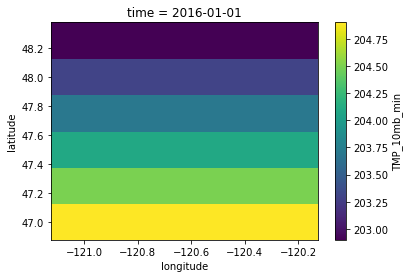

In [94]:
#this demonstrates wihtin a region how much data we have versus masked out areas
region_data['WA Cascades East, Central'].TMP_10mb_min.plot()

In [95]:
#find union of all lat/lon/region to just grids with values
#the process to filter the lat/lon is expensive but we need to do it here (1-5 seconds per region)
#as the helps the batch process select relevant data
lat_lon_union = pd.DataFrame()
for r in region_data.keys():
    print(r)
    region_df = region_data[r].stack(lat_lon = ('latitude', 'longitude')).lat_lon.to_dataframe()
    tmp_df = pd.DataFrame.from_records(region_df['lat_lon'], columns=['latitude', 'longitude'])
    indexes_to_drop = []
    for index, row in tmp_df.iterrows():
        #TODO: there might be a more efficient way than doing this one by one?
        if 0 == np.count_nonzero(region_data[r].to_array().sel(latitude=row['latitude'], longitude=row['longitude']).stack(time_var = ('time', 'variable')).dropna(dim='time_var', how='all').values):
            indexes_to_drop.append(index)
    tmp_df.drop(indexes_to_drop, axis=0, inplace=True)
    tmp_df[region_col] = r
    lat_lon_union = pd.concat([lat_lon_union, tmp_df])

Mt Hood
Olympics
Snoqualmie Pass
Stevens Pass
WA Cascades East, Central
WA Cascades East, North
WA Cascades East, South
WA Cascades West, Central
WA Cascades West, Mt Baker
WA Cascades West, South


In [96]:
lat_lon_union.head()

,latitude,longitude,UnifiedRegion
0,45.25,-121.75,Mt Hood
1,45.25,-121.50,Mt Hood
0,47.50,-123.75,Olympics
1,47.50,-123.50,Olympics
2,47.50,-123.25,Olympics


In [97]:
#cache the data
lat_lon_union.to_csv(processed_path + 'lat_lon_union.csv')

In [98]:
#load the cached data
lat_lon_union = pd.read_csv(processed_path + 'lat_lon_union.csv',float_precision='round_trip')

In [99]:
lat_lon_union.shape

(143, 4)

In [100]:
#join in with the labels so we have a label per lat/lon pair
lat_lon_union = lat_lon_union.set_index(region_col, drop=False).join(labels.set_index(region_col, drop=False), how='left', lsuffix='left', rsuffix='right')

In [101]:
#total number of datapoints
lat_lon_union.shape

(66771, 302)

In [102]:
def get_state_for_region(region):
    for k in regions.keys():
        #print('on k ' + k)
        #print('with regions: ' + regions[k])
        if region in regions[k]:
            return k
    
    raise Exception('No region with name ' + region)

In [103]:
def create_filename_list(region, end_date, lookback_days):
    earliest_data, season = date_to_season(end_date)
    if earliest_data == -1:
        return None
    state = get_state_for_region(region)
    filenames = []
    reg = region
    for i in range(lookback_days):
        d = np.datetime64(end_date) - np.timedelta64(i, 'D')
        if d < earliest_data:
            break #no more data
        filenames.insert(0,processed_path + '/' + season + '/' + state + '/Region_' + reg + '_' + pd.to_datetime(d).strftime('%Y%m%d') + '.nc')
    return filenames
        
        

In [104]:
#debug
processed_path

'/media/scottcha/E1/Data/OAPMLData//3.GFSFiltered1xInterpolation/'

In [105]:
#utility to get data for a specific point
def get_data_zarr(region, lat, lon, lookback_days, date):
    #print(region + ' ' + str(lat) + ', ' + str(lon) + ' ' + str(date))
    state = get_state_for_region(region)
    earliest_data, season = date_to_season(date)
    path = processed_path + '/' + season + '/' + state + '/Region_' + region + '.zarr'
    tmp_ds = xr.open_zarr(path, consolidated=True)
    start_day = date - np.timedelta64(lookback_days-1, 'D')
    #print('start day ' + str(start_day))
    tmp_ds = tmp_ds.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice(start_day, date))
    
    date_values_pd = pd.date_range(start_day, periods=lookback_days, freq='D')
    #reindex should fill missing values with NA
    tmp_ds = tmp_ds.reindex({'time': date_values_pd})
    
    tmp_ds = tmp_ds.reset_index(dims_or_levels='time', drop=True).load()
    return tmp_ds

In [106]:
#test the method
#get_data_zarr('South San Juan Mountains', 37.5217391, -107.994413, 180, np.datetime64('2015-11-17')).sel(variable='SNOD_surface_avg').vars.values

### Primary method to take a set of lables and pull the data for it
the data is large so generally this needs to be done it batches
and then stored on disk

In [107]:

def process_sample(iter_tuple, lookback_days):
    row = iter_tuple[1]
    d = row[parsed_date_col] 
    
    lat = row['latitude']
    lon = row['longitude']
    reg = row[region_col]            
    #print('region: ' + reg + ' date ' + str(d))
    ds = get_data_zarr(reg, lat, lon, lookback_days, d)
    
    #print("actual data")
    if ds.time.shape[0] != lookback_days:    
        print(ds)
        print('Need to drop! Error, incorrect shape ' + str(ds.time.shape[0]) + ' on time ' + str(d))
    return (ds)


###for a set of labels and a target column from the labels set create the ML data
def get_xr_batch(labels, lookback_days=14, batch_size=64, y_column='Day1DangerAboveTreeline', label_values=['Low', 'Moderate', 'Considerable', 'High'], oversample={'Low':True, 'Moderate':False, 'Considerable':False, 'High':True}, random_state=1, n_jobs=-1):
    labels_data = labels
    
    X = None     
    y = None 

    first = True   
    first_y = True
    num_in_place = 0
    error_files = []
    while num_in_place < batch_size:
        if not first:
            #if we didn't meet the full batch size 
            #continue appending until its full
            #if num_in_place % 5 == 0:
            print('Filling remaining have ' + str(num_in_place))
            sample_size = batch_size-num_in_place
            if sample_size < len(label_values):
                sample_size = len(label_values)
        else: 
            sample_size = batch_size
        
        batch_lookups = []
        for l in label_values:
            print('    on label: ' + l + ' with samplesize: ' + str(int(sample_size/len(label_values))))
            print('    len: ' + str(len(labels_data[labels_data[y_column]==l])))
            batch_lookups.append(labels_data[labels_data[y_column]==l].sample(int(sample_size/len(label_values)), random_state=random_state))
            if not oversample[l]:
                labels_data = labels_data.drop(batch_lookups[-1].index, axis=0)
                
        #TODO: if the labels set doesn't have a degree of 4 then this needs to be modified
        #get 1/4 of the data from 'High' and 1/4 from low
        #this is basically a naive oversampling strategy since Low/High 
        #populations are much smaller that moderate/considerable
        #TODO: add Extreme in (or possibly make it high)        
        batch_lookup_low = labels_data[labels_data[y_column]=='Low'].sample(int(sample_size/4), random_state=random_state)
        batch_lookup_moderate = labels_data[labels_data[y_column]=='Moderate'].sample(int(sample_size/4), random_state=random_state)
        batch_lookup_considerable = labels_data[labels_data[y_column]=='Considerable'].sample(int(sample_size/4), random_state=random_state)
        batch_lookup_high = labels_data[labels_data[y_column]=='High'].sample(int(sample_size/4), random_state=random_state)
        
        #remove moderate and considerable, 
        labels_data = labels_data.drop(batch_lookup_moderate.index, axis=0)
        labels_data = labels_data.drop(batch_lookup_considerable.index, axis=0)
        #keeping high and low if set to oversample
        if not oversample:    
            labels_data = labels_data.drop(batch_lookup_high.index, axis=0)
            labels_data = labels_data.drop(batch_lookup_low.index, axis=0)
                            
        #sample frac=1 causes the data to be shuffled
        batch_lookup = pd.concat(batch_lookups).sample(frac=1)
        #print('lookup shape: ' + str(batch_lookup.shape))
        batch_lookup.reset_index(inplace=True, drop=True)
        
        func = partial(process_sample, lookback_days=lookback_days)        
        data = Parallel(n_jobs=n_jobs)(map(delayed(func), batch_lookup.iterrows()))
        

        #print('data has len: ' + str(len(data)))
        to_delete = []
        #delete backwards so we can delete by index
        for i in reversed(range(len(data))):
            #print('on i: ' + str(i))
            if data[i] is None:
                print('deleting ' + str(i))
                del data[i]
                batch_lookup = batch_lookup.drop(i, axis=0)
                
        
        for d in sorted(to_delete, reverse=True):
            print('deleting ' + str(d))
            del data[d]
            
        for f in data:
            if f is None:
                print('Still have none in data')
            
        if first and len(data) > 0:                            
            X = xr.concat(data, dim='sample') 
            y = batch_lookup
            first = False            
        elif not first and len(data) > 0:    
            X_t = xr.concat(data, dim='sample')
            X = xr.concat([X, X_t], dim='sample')#, coords='all', compat='override') 
            y = pd.concat([y, batch_lookup], axis=0)
     
        num_in_place = y.shape[0]
        #print('Num: ' + str(num_in_place))
                
    y = y.reset_index(drop=True)
    X = X.reindex({'sample': y.apply(lambda r: str(r[parsed_date_col]) + ': ' + r[region_col], axis=1)})
    return X, y, labels_data







In [108]:
#define the split between train and test
date_min = np.datetime64('2015-11-01')
date_max = np.datetime64('2019-04-30')
train_date_cutoff = np.datetime64('2018-11-01')


In [109]:
#split the train/test data
labels_data_union = lat_lon_union[lat_lon_union[parsed_date_col] >= date_min]
labels_data_union = labels_data_union[labels_data_union[parsed_date_col] <= date_max]
#copy so we can delete the overall data and only keep the filtered
labels_data_train = labels_data_union[labels_data_union[parsed_date_col] <= train_date_cutoff].copy()
labels_data_test = labels_data_union[labels_data_union[parsed_date_col] > train_date_cutoff].copy()


In [110]:
labels_data_train.reset_index(inplace=True)
labels_data_test.reset_index(inplace=True)

In [111]:
len(labels_data_train)

62905

In [112]:
labels_data_train.head()

,UnifiedRegion,Unnamed: 0,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,...,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date,season,Day1DangerAboveTreelineValue,Day1DangerAboveTreelineWithTrend
0,Mt Hood,0,45.25,-121.75,Mt Hood,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-05,15-16,1.0,Moderate_Initial
1,Mt Hood,0,45.25,-121.75,Mt Hood,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-06,15-16,1.0,Moderate_Flat
2,Mt Hood,0,45.25,-121.75,Mt Hood,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-07,15-16,2.0,Considerable_Rising
3,Mt Hood,0,45.25,-121.75,Mt Hood,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-08,15-16,2.0,Considerable_Flat
4,Mt Hood,0,45.25,-121.75,Mt Hood,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,2015-12-09,15-16,1.0,Moderate_Falling


In [113]:
labels_data_train['Day1DangerAboveTreeline'].value_counts()

Moderate        27982
Considerable    25588
High             5715
Low              2289
no-data          1272
Extreme            59
Name: Day1DangerAboveTreeline, dtype: int64

In [114]:
labels_data_test['Day1DangerAboveTreeline'].value_counts()

Considerable    1302
Moderate        1183
no-data          741
Low              423
High             217
Name: Day1DangerAboveTreeline, dtype: int64

In [115]:
labels_data_train[region_col].value_counts()

WA Cascades East, North       11000
WA Cascades West, South       10560
WA Cascades East, Central     10560
WA Cascades West, Central      8800
WA Cascades East, South        6600
WA Cascades West, Mt Baker     6585
Olympics                       5280
Snoqualmie Pass                1760
Stevens Pass                    880
Mt Hood                         880
Name: UnifiedRegion, dtype: int64

In [116]:
labels_data_test[region_col].value_counts()

WA Cascades West, South       912
WA Cascades East, Central     600
WA Cascades East, North       575
WA Cascades West, Central     520
WA Cascades West, Mt Baker    510
WA Cascades East, South       285
Olympics                      240
Snoqualmie Pass               136
Stevens Pass                   48
Mt Hood                        40
Name: UnifiedRegion, dtype: int64

In [117]:
#test the method to get one batch
#8 core 1 min
#fastest is use multiprocessing but no dask
%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, lookback_days=7, batch_size=10, n_jobs=14)

    on label: Low with samplesize: 2
    len: 2289
    on label: Moderate with samplesize: 2
    len: 27982
    on label: Considerable with samplesize: 2
    len: 25588
    on label: High with samplesize: 2
    len: 5715
Filling remaining have 8
    on label: Low with samplesize: 1
    len: 2289
    on label: Moderate with samplesize: 1
    len: 27978
    on label: Considerable with samplesize: 1
    len: 25584
    on label: High with samplesize: 1
    len: 5715
CPU times: user 2.82 s, sys: 1.15 s, total: 3.96 s
Wall time: 5.89 s


In [45]:
#For trending lables define how to oversample them
label_filters = ['Moderate_Flat', 
                 'Considerable_Flat', 
                 'Low_Flat', 
                 'Moderate_Falling',
                 'Considerable_Rising',
                 'High_Rising',
                 'Considerable_Falling',
                 'Low_Falling',
                 'Moderate_Rising',
                 'High_Flat',
                 'Moderate_Initial',
                 'Considerable_Initial',
                 'Low_Initial']
label_oversample = {'Moderate_Flat':False, 
                 'Considerable_Flat':False, 
                 'Low_Flat':False, 
                 'Moderate_Falling':False,
                 'Considerable_Rising':False,
                 'High_Rising':True,
                 'Considerable_Falling':True,
                 'Low_Falling':True,
                 'Moderate_Rising':True,
                 'High_Flat':True,
                 'Moderate_Initial':False,
                 'Considerable_Initial':False,
                 'Low_Initial':False}

In [46]:
#check process to generate a batch with trending labels
#X, y, remaining_labels_train = get_xr_batch(remaining_labels_train, lookback_days=180, batch_size=64, y_column='Day1DangerAboveTreelineWithTrend', label_values=label_filters, oversample=label_oversample, n_jobs=14)

In [118]:
y_train['Day1DangerAboveTreeline'].value_counts()

High            3
Moderate        3
Considerable    3
Low             3
Name: Day1DangerAboveTreeline, dtype: int64

In [119]:
def prepare_batch_simple(X, y):
    #ensure, X and y indexes are aligned
    X = X.sortby(['sample', 'latitude', 'longitude'])
    
    sample = y.apply(lambda row: '{}: {}'.format(row['parsed_date'], row['UnifiedRegion']), axis=1)
    y['sample'] = sample
    y = y.set_index(['sample', 'latitude', 'longitude'])
    y.sort_index(inplace=True)    
    y.reset_index(drop=False, inplace=True)
    return X, y

In [120]:
#method to enable batches to be generated based on total amount of data as well as batch size
#batches stores as zarr & parquet
def cache_batches(labels, batch_size=50, total_rows=10000, train_or_test='train', lookback_days=180, n_jobs=14):
    remaining_labels = labels
    for i in range(0, total_rows, batch_size):
        print(str(datetime.datetime.now()) + ' On ' + str(i) + ' of ' + str(total_rows))
        X, y, remaining_labels = get_xr_batch(remaining_labels, lookback_days=lookback_days, batch_size=batch_size, n_jobs=n_jobs)
        X.to_zarr(ml_path + 'X_' + train_or_test + '_' + str(i/batch_size) + '.zarr')
        y.to_parquet(ml_path + 'y_' + train_or_test + '_' + str(i/batch_size) + '.parquet')
    return remaining_labels

In [121]:
#method to enable batches to be generated based on total amount of data as well as batch size
#batches returned for further processing
def cache_batches_np(labels, batch_size=50, total_rows=10000, train_or_test='train', lookback_days=180, y_column='Day1DangerAboveTreeline', label_values=label_filters, oversample=label_oversample, n_jobs=14):
    remaining_labels = labels
    for i in range(0, total_rows, batch_size):
        print(str(datetime.datetime.now()) + ' *On ' + str(i) + ' of ' + str(total_rows))
        X, y, remaining_labels = get_xr_batch(remaining_labels, lookback_days=lookback_days, batch_size=batch_size, y_column=y_column, n_jobs=n_jobs)         
        
    return prepare_batch_simple(X, y), remaining_labels

In [122]:
#important method to generate a set of batches and store them in a memmapped numpy array
#this is the technique used to prep data for timeseriesai notebook
def create_memmapped(remaining_labels, train_or_test = 'train', num_rows = 100000, batch=0, batch_size=500):
    # Save a small empty array
    X_temp_fn = ml_path + '/temp_X.npy'
    np.save(X_temp_fn, np.empty(1))
    
    # Create a np.memmap with desired dtypes and shape of the large array you want to save.
    # It's just a placeholder that doesn't contain any data
    X_fn = ml_path + '/X' + train_or_test + '_batch_' + str(batch) + '_on_disk.npy'
    X = np.memmap(X_temp_fn, dtype='float32', shape=(num_rows, 1131, 180))

    # We are going to create a loop to fill in the np.memmap
    start = 0
    for i in range(0, num_rows, batch_size):
        print('On ' + str(i) + ' of ' + str(num_rows))
        # You now grab a chunk of your data that fits in memory
        # This could come from a pandas dataframe for example        
        dfs, remaining_labels = cache_batches_np(remaining_labels, batch_size=batch_size, total_rows=500)
        #need to make sure all the variables are in the same order (there was an issue that they weren't between train and test sets)
        X_df = dfs[0].sortby('variable')
        y_df = dfs[1]
        end = start + batch_size

        # I now fill a slice of the np.memmap         
        X[start:end] = X_df.vars.values[:batch_size] #sometimes the process will add a few extras, filter them
  
        #just save y as parquet
        y_df[:batch_size].to_parquet(ml_path + '/y_' + train_or_test + '_batch_' + str(batch) + '_' + str(i/batch_size) + '.parquet')
        start = end
        del X_df, y_df

    #I can now remove the temp file I created
    os.remove(X_temp_fn)

    # Once the data is loaded on the np.memmap, I save it as a normal np.array
    np.save(X_fn, X)
    return remaining_labels



In [123]:
#Set up the label initial state
remaining_labels_train = labels_data_train
remaining_labels_test = labels_data_test

In [124]:
#create one memmapped file with 50000 rows
%time remaining_labels_train = create_memmapped(remaining_labels_train, train_or_test = 'train', num_rows=25000, batch=0)

On 0 of 25000
2020-10-31 18:13:27.036493 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 27982
    on label: Considerable with samplesize: 125
    len: 25588
    on label: High with samplesize: 125
    len: 5715


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


On 500 of 25000
2020-10-31 18:14:13.829826 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 27732
    on label: Considerable with samplesize: 125
    len: 25338
    on label: High with samplesize: 125
    len: 5715
On 1000 of 25000
2020-10-31 18:14:56.506986 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 27482
    on label: Considerable with samplesize: 125
    len: 25088
    on label: High with samplesize: 125
    len: 5715
On 1500 of 25000
2020-10-31 18:15:38.340460 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 27232
    on label: Considerable with samplesize: 125
    len: 24838
    on label: High with samplesize: 125
    len: 5715
On 2000 of 25000
2020-10-31 18:16:21.634649 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with sampl

    on label: High with samplesize: 125
    len: 5715
On 15000 of 25000
2020-10-31 18:45:11.958257 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 20482
    on label: Considerable with samplesize: 125
    len: 18088
    on label: High with samplesize: 125
    len: 5715
On 15500 of 25000
2020-10-31 18:45:46.113052 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 20232
    on label: Considerable with samplesize: 125
    len: 17838
    on label: High with samplesize: 125
    len: 5715
On 16000 of 25000
2020-10-31 18:48:44.993866 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 19982
    on label: Considerable with samplesize: 125
    len: 17588
    on label: High with samplesize: 125
    len: 5715
On 16500 of 25000
2020-10-31 18:51:56.021180 *On 0 of 500
    on label: Low with samp

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


On 21000 of 25000
2020-10-31 19:21:09.167855 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 17482
    on label: Considerable with samplesize: 125
    len: 15088
    on label: High with samplesize: 125
    len: 5715
On 21500 of 25000
2020-10-31 19:27:26.274192 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 17232
    on label: Considerable with samplesize: 125
    len: 14838
    on label: High with samplesize: 125
    len: 5715
On 22000 of 25000
2020-10-31 19:28:02.183569 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with samplesize: 125
    len: 16982
    on label: Considerable with samplesize: 125
    len: 14588
    on label: High with samplesize: 125
    len: 5715
On 22500 of 25000
2020-10-31 19:35:11.436811 *On 0 of 500
    on label: Low with samplesize: 125
    len: 2289
    on label: Moderate with 

In [46]:
#create several memapped files
#we do this as the technique to create one has some memory limitations
#also due to the memory limitations sometimes this process runs out of memory and crashes
#which is why we cache the label state after every iteration so we can restart at that state
for i in range(0, 7):
    print('On ' + str(i))
    remaining_labels_train = create_memmapped(remaining_labels_train, train_or_test = 'train', num_rows=50000, batch=i)
    
    with open(ml_path + 'remaining_labels_train.p', 'wb' ) as file:
        pickle.dump(remaining_labels_train, file)
    print(str(len(remaining_labels_train)))

On 3
On 0 of 50000
2020-09-21 19:54:21.965066 *On 0 of 500
data has len: 500
On 500 of 50000
2020-09-21 19:55:47.445798 *On 0 of 500
data has len: 500
On 1000 of 50000
2020-09-21 19:57:08.174319 *On 0 of 500
data has len: 500
On 1500 of 50000
2020-09-21 19:58:26.428457 *On 0 of 500
data has len: 500
On 2000 of 50000
2020-09-21 19:59:43.378711 *On 0 of 500
data has len: 500
On 2500 of 50000
2020-09-21 20:01:01.193312 *On 0 of 500
data has len: 500
On 3000 of 50000
2020-09-21 20:02:17.416732 *On 0 of 500
data has len: 500
On 3500 of 50000
2020-09-21 20:03:34.166300 *On 0 of 500
data has len: 500
On 4000 of 50000
2020-09-21 20:04:51.048458 *On 0 of 500
data has len: 500
On 4500 of 50000
2020-09-21 20:06:08.336469 *On 0 of 500
data has len: 500
On 5000 of 50000
2020-09-21 20:07:25.677111 *On 0 of 500
data has len: 500
On 5500 of 50000
2020-09-21 20:08:42.043586 *On 0 of 500
data has len: 500
On 6000 of 50000
2020-09-21 20:09:59.349174 *On 0 of 500
data has len: 500
On 6500 of 50000
2020-09

data has len: 500
On 4500 of 50000
2020-09-21 22:27:42.406438 *On 0 of 500
data has len: 500
On 5000 of 50000
2020-09-21 22:29:00.980784 *On 0 of 500
data has len: 500
On 5500 of 50000
2020-09-21 22:30:19.400271 *On 0 of 500
data has len: 500
On 6000 of 50000
2020-09-21 22:31:37.417667 *On 0 of 500
data has len: 500
On 6500 of 50000
2020-09-21 22:32:54.229509 *On 0 of 500
data has len: 500
On 7000 of 50000
2020-09-21 22:34:10.966297 *On 0 of 500
data has len: 500
On 7500 of 50000
2020-09-21 22:35:29.212445 *On 0 of 500
data has len: 500
On 8000 of 50000
2020-09-21 22:36:49.508908 *On 0 of 500
data has len: 500
On 8500 of 50000
2020-09-21 22:38:09.523332 *On 0 of 500
data has len: 500
On 9000 of 50000
2020-09-21 22:39:28.063893 *On 0 of 500
data has len: 500
On 9500 of 50000
2020-09-21 22:40:46.071492 *On 0 of 500
data has len: 500
On 10000 of 50000
2020-09-21 22:42:05.835182 *On 0 of 500
data has len: 500
On 10500 of 50000
2020-09-21 22:43:23.485107 *On 0 of 500
data has len: 500
On 11

OSError: [Errno 107] Transport endpoint is not connected

In [125]:
#same process for test
for i in range(0, 1):
    print('On ' + str(i))
    remaining_labels_test = create_memmapped(remaining_labels_test, train_or_test = 'test', num_rows=1000, batch=i)
    
    with open(ml_path + 'remaining_labels_test.p', 'wb' ) as file:
        pickle.dump(remaining_labels_test, file)
    print(str(len(remaining_labels_test)))

On 0
On 0 of 1000
2020-10-31 20:33:23.828314 *On 0 of 500
    on label: Low with samplesize: 125
    len: 423
    on label: Moderate with samplesize: 125
    len: 1183
    on label: Considerable with samplesize: 125
    len: 1302
    on label: High with samplesize: 125
    len: 217
On 500 of 1000
2020-10-31 20:33:59.649573 *On 0 of 500
    on label: Low with samplesize: 125
    len: 423
    on label: Moderate with samplesize: 125
    len: 933
    on label: Considerable with samplesize: 125
    len: 1052
    on label: High with samplesize: 125
    len: 217
2866


In [126]:
print(str(len(labels_data_train)))
print(str(len(remaining_labels_train)))

62905
37905


In [5]:
#open the remaining labels if we want to do more
with open( ml_path + 'remaining_labels_train.p', 'rb' ) as file:
    remaining_labels_train = pickle.load(file)

In [44]:

with open(ml_path + 'remaining_labels_train.p', 'wb' ) as file:
    pickle.dump(remaining_labels_train, file)

In [9]:
remaining_labels_train['parsed_date'].value_counts().sort_index(ascending=False)

2018-04-30      34
2018-04-29    1394
2018-04-28    1584
2018-04-27    1369
2018-04-26    1494
              ... 
2015-11-07      28
2015-11-06      90
2015-11-04     319
2015-11-03     131
2015-11-01     131
Name: parsed_date, Length: 505, dtype: int64

In [95]:
create_memmapped(remaining_labels_test, train_or_test = 'test', num_rows=20000)

On 0 of 500
2020-09-11 18:41:13.399880 *On 0 of 500
data has len: 500
On 500 of 500
2020-09-11 18:41:59.255300 *On 0 of 500
data has len: 500
On 1000 of 500
2020-09-11 18:42:44.762543 *On 0 of 500
data has len: 500
On 1500 of 500
2020-09-11 18:43:30.075925 *On 0 of 500
data has len: 500
On 2000 of 500
2020-09-11 18:44:14.144173 *On 0 of 500
data has len: 500
On 2500 of 500
2020-09-11 18:44:58.135322 *On 0 of 500
data has len: 500
On 3000 of 500
2020-09-11 18:45:44.736670 *On 0 of 500
data has len: 500
On 3500 of 500
2020-09-11 18:46:28.287866 *On 0 of 500
data has len: 500
On 4000 of 500
2020-09-11 18:47:13.928944 *On 0 of 500
data has len: 500
On 4500 of 500
2020-09-11 18:47:58.853033 *On 0 of 500
data has len: 500
On 5000 of 500
2020-09-11 18:48:43.704555 *On 0 of 500
data has len: 500
On 5500 of 500
2020-09-11 18:49:29.227995 *On 0 of 500
data has len: 500
On 6000 of 500
2020-09-11 18:50:14.043266 *On 0 of 500
data has len: 500
On 6500 of 500
2020-09-11 18:51:00.567094 *On 0 of 500


In [36]:
X_tmp = np.load(ml_path + '/X_on_disk.npy', mmap_mode='r')

In [31]:
y.head()

,sample,latitude,longitude,UnifiedRegion,Unnamed: 0,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,...,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date,season
0,2015-11-15 00:00:00: North San Juan Mountains,38.008696,-106.273743,North San Juan Mountains,306,North San Juan Mountains,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-15,15-16
1,2015-11-16 00:00:00: South San Juan Mountains,37.704348,-106.703911,South San Juan Mountains,409,South San Juan Mountains,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-16,15-16
2,2015-11-17 00:00:00: North San Juan Mountains,37.886957,-107.318436,North San Juan Mountains,211,North San Juan Mountains,no-data,no-data,no-data,no-data,...,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-17,15-16
3,2015-11-17 00:00:00: South San Juan Mountains,37.521739,-107.994413,South San Juan Mountains,283,South San Juan Mountains,no-data,no-data,no-data,no-data,...,1,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-17,15-16
4,2015-11-22 00:00:00: North San Juan Mountains,38.069565,-106.826816,North San Juan Mountains,336,North San Juan Mountains,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-22,15-16


In [127]:
#if we have created multiple numpy data files on disk we can now look at 
#concating them all to one large file
filenames = []
for i in range(1):
    filenames.append(ml_path + '/Xtrain_batch_' + str(i) + '_on_disk.npy')

filenames.append(ml_path + '/Xtest_batch_0_on_disk.npy')



In [128]:
filenames

['/media/scottcha/E1/Data/OAPMLData//4.MLData/Xtrain_batch_0_on_disk.npy',
 '/media/scottcha/E1/Data/OAPMLData//4.MLData/Xtest_batch_0_on_disk.npy']

In [129]:
#method to concat the files to one final large data file
def concat_memapped(to_concat_filenames, dim_1_size=1131, dim_2_size=180):
    to_concat = []
    for i in range(len(to_concat_filenames)):
        to_concat.append(np.load(to_concat_filenames[i], mmap_mode='r'))
    
    dim_0_size = 0
    
    for i in range(len(to_concat)):
        dim_0_size += to_concat[i].shape[0]
        assert(to_concat[i].shape[1] == dim_1_size)
        assert(to_concat[i].shape[2] == dim_2_size)
    
    X_temp_fn = ml_path + '/temp_X.npy'
    np.save(X_temp_fn, np.empty(1))
    X_fn = ml_path + '/X_all.npy'
    X = np.memmap(X_temp_fn, dtype='float32', shape=(dim_0_size, dim_1_size, dim_2_size))
    dim_0_start = 0
    for i in range(len(to_concat)):
        print('On file ' + str(i) + ' of ' + str(len(to_concat)))
        dim_0 = to_concat[i].shape[0]
        X[dim_0_start:dim_0_start+dim_0] = to_concat[i]
        dim_0_start += dim_0
        

    #I can now remove the temp file I created
    os.remove(X_temp_fn)

    # Once the data is loaded on the np.memmap, I save it as a normal np.array
    np.save(X_fn, X)
    del to_concat
    
        

In [130]:
concat_memapped(filenames)

On file 0 of 2
On file 1 of 2
